In [ ]:
'''''
Since the dataset was imbalanced in the first place I wanted to see if syntheticc upsampling techniques would add any 
considerable change in model performance.

I used Border line smote technique in which minority examples near decision boundary 
(these are hard to classify points) are oversampled



In conclusion no noticable imporvement in performance was observed for our 2 best classifiers :

xgboost and stacked ensemble, however stacked ensemble at smote ratio of 0.32 showed considerable imporvement in
in classification of minority samples without noticable changes to accuracy of majority samples.
Its AUC score remained almost at par with its previous score.

Seeing this behaviour I finalized smote-borderline based stacked ensemble model as my final model.

I further tried to tune xgboost by hyper parameters search explored in the next notebook


''''''

In [1]:
### Python imports
import nbimporter
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

####Importing  Data cleaning,scoring and confusion matrix from functions.ipynb(user created)
from functions import data_clean
from functions import training_predict
from functions import data_clean
from functions import confusion_matrix_plot




### Importing pipelines and preprocessors

from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,StandardScaler,RobustScaler
from sklearn.compose import ColumnTransformer


###Importing model selection and validation metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, average_precision_score ,auc,roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold

#### Importing models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier , StackingClassifier


### IMporting our sampling strategy
from imblearn.over_sampling import BorderlineSMOTE

Importing Jupyter notebook from functions.ipynb


Using TensorFlow backend.


In [2]:
#### Reading dataset
data_train=pd.read_csv("exercise_01_train.csv")
#### Cleaning data using custom function
data_train=data_clean(data_train)

In [3]:

##target variable
labels=data_train["y"]
#### Rest of features
all_data=data_train.drop(columns=["y"])

##Numeric features
numeric_features =  all_data.select_dtypes(include=["float","int"]).columns
### Categorical features
categorical_features=all_data.select_dtypes(exclude=["float","int"]).columns

#### Selecting Median imputer as startegy for imputing missing values and Robust scaler as strategy for 
#### standardizing data.Since the missing values in EDA
####Robust scaler was slightly better at model performance than standard scaler 
####because of its robustness to outliers


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

#### Selecting simple imputer as startegy for imputing missing values to "missing" category 
#### Onehot encoding  as next step in pipeline for categorical variables




categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])




##### Applying preprocessing steps as column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],remainder="passthrough")









In [4]:
### Creating a train-test split for model testing and validation
X_train, X_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.2,random_state=42,stratify=labels)

In [43]:
### Retaining the parameters of models from baselines
### Scale_pos_weight will be contnuosly updated(1/imbalance-ratio) within the loop to adjust 
### for changes in imbalance ratio

### Search Space for smote ratios of minority class . 
smote_values=np.linspace(26,50,5)

xgb = XGBClassifier(random_state= 42)


log_reg = LogisticRegression(random_state= 42,class_weight='balanced')

rf = RandomForestClassifier(random_state= 42,class_weight='balanced')

gbm=GradientBoostingClassifier(random_state=42)

##estimators for voting classifier
estimator_vote=classifiers = [("logistic regression ",
    LogisticRegression(random_state=42,class_weight='balanced')),
                          
                          ("Random Forest" ,  RandomForestClassifier(random_state=42,class_weight='balanced')),
    

 ("GBM" ,  GradientBoostingClassifier(random_state=42))]

#voting classifier
voting_clf=VotingClassifier(estimators=estimator_vote, voting='soft')

##estimators for stacking classifer

estimator_stacked = [
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ("GBM" ,  GradientBoostingClassifier(random_state=42))
    ]





#stacking classifier
stacked_clf=StackingClassifier(estimators=estimator_stacked, final_estimator= LogisticRegression(random_state=42,class_weight='balanced'))

#### start Measuring time for loop completion
start = time.time()

panel = {} # Saves key as smoting ratio and dictionary is the result of each classifier

for value in smote_values:
    sm = BorderlineSMOTE(value,kind='borderline-1',random_state=42)
    
    xgb = XGBClassifier(random_state= 42,scale_pos_weight=1/value)
    print ('Loop for smote value {} started at {}'.format(value, datetime.now().strftime("%H:%M:%S")))
   
    predictors = {} # Initializing a dictionary to store training and testing data
 
    for model in [log_reg, rf, gbm,xgb,voting_clf,stacked_clf]:
        model_name = model.__class__.__name__
        predictors[model_name]  = {}
        pipe=make_pipeline(preprocessor,sm,model)
        predictors[model_name] =  training_predict(pipe, X_train, y_train, X_test, y_test) #Scores that is returned from trainer goes to
    
    panel[value] = predictors  # the respective predictor
            
    print ('Loop Ended at {}'.format(datetime.now().strftime("%H:%M:%S")))
    print ('\n')
    
print ('Loop took {} mins'.format((time.time() - start) / 60))

Loop for smote value 0.26 started at 06:45:34
Loop Ended at 07:09:16


Loop for smote value 0.32 started at 07:09:16
Loop Ended at 07:32:57


Loop for smote value 0.38 started at 07:32:57
Loop Ended at 07:57:36


Loop for smote value 0.44 started at 07:57:36
Loop Ended at 08:23:12


Loop for smote value 0.5 started at 08:23:12
Loop Ended at 08:49:51


Loop took 124.2728422999382 mins


In [44]:
### OBSERVING RESULTS FROM TRIALS

smote_iterated_df = pd.DataFrame()
for key in panel:
    temp_df = pd.DataFrame(panel[key]).T
    temp_df['Smote'] = key
    temp_df.index.name = 'Class'
    temp_df.reset_index(inplace= True)
    temp_df.set_index(['Smote','Class'], inplace= True)
    smote_iterated_df = smote_iterated_df.append(temp_df)
smote_iterated_df

auc  AP-SCORE  Recall_test  \
Smote Class                                                         
0.26  LogisticRegression          0.911767  0.782943     0.824736   
      RandomForestClassifier      0.975475  0.939234     0.318832   
      GradientBoostingClassifier  0.954236  0.891934     0.593536   
      XGBClassifier               0.983910  0.973697     0.922312   
      VotingClassifier            0.956269  0.898578     0.712244   
      StackingClassifier          0.975772  0.944803     0.928527   
0.32  LogisticRegression          0.911444  0.782318     0.827222   
      RandomForestClassifier      0.976378  0.933556     0.364823   
      GradientBoostingClassifier  0.954217  0.886740     0.631448   
      XGBClassifier               0.984242  0.974582     0.924798   
      VotingClassifier            0.956558  0.895499     0.730889   
      StackingClassifier          0.976371  0.939069     0.911746   
0.38  LogisticRegression          0.911084  0.781181     0.831572   
      RandomForestClassifier      0.974499  0.929382     0.396520   
      GradientBoostingClassifier  0.954591  0.886374     0.655687   
      XGBClassifier               0.983635  0.971967     0.915475   
      VotingClassifier            0.956388  0.894843     0.751398   
      StackingClassifier          0.974969  0.935981     0.896209   
0.44  LogisticRegression          0.910866  0.781844     0.832815   
      RandomForestClassifier      0.972804  0.924618     0.430702   
      GradientBoostingClassifier  0.951268  0.877789     0.665009   
      XGBClassifier               0.983786  0.972419     0.919204   
      VotingClassifier            0.954921  0.891302     0.757613   
      StackingClassifier          0.972846  0.929914     0.879428   
0.50  LogisticRegression          0.910749  0.780916     0.831572   
      RandomForestClassifier      0.972119  0.923434     0.452455   
      GradientBoostingClassifier  0.949631  0.872775     0.658794   
      XGBClassifier               0.983706  0.973199     0.918583   
      VotingClassifier            0.954015  0.888531     0.765693   
      StackingClassifier          0.972451  0.928499     0.853325   

                                  Precision_test  F1_Score_test  
Smote Class                                                      
0.26  LogisticRegression                0.556628       0.664663  
      RandomForestClassifier            0.990347       0.482370  
      GradientBoostingClassifier        0.953094       0.731520  
      XGBClassifier                     0.947033       0.934509  
      VotingClassifier                  0.905213       0.797217  
      StackingClassifier                0.804957       0.862338  
0.32  LogisticRegression                0.554815       0.664172  
      RandomForestClassifier            0.988215       0.532910  
      GradientBoostingClassifier        0.917796       0.748159  
      XGBClassifier                     0.948980       0.936733  
      VotingClassifier                  0.874349       0.796209  
      StackingClassifier                0.821849       0.864467  
0.38  LogisticRegression                0.556110       0.666501  
      RandomForestClassifier            0.986090       0.565603  
      GradientBoostingClassifier        0.899403       0.758447  
      XGBClassifier                     0.942418       0.928752  
      VotingClassifier                  0.860498       0.802256  
      StackingClassifier                0.823059       0.858078  
0.44  LogisticRegression                0.557636       0.667996  
      RandomForestClassifier            0.970588       0.596642  
      GradientBoostingClassifier        0.889443       0.761024  
      XGBClassifier                     0.946863       0.932829  
      VotingClassifier                  0.854839       0.803295  
      StackingClassifier                0.846292       0.862542  
0.50  LogisticRegression                0.557036       0.667165  
      RandomForestClassifier            0.979812

{'auc': 0.9837458848818145, 'AP-SCORE': 0.9740714701468852, 'Recall_test': 0.9154754505904288, 'Precision_test': 0.9583604424202993, 'F1_Score_test': 0.9364272091544817}
Confusion matrix, without normalization
Normalized confusion matrix


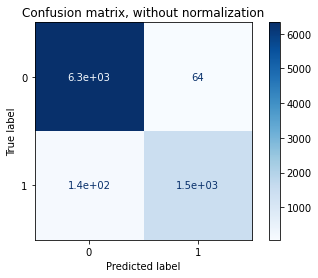

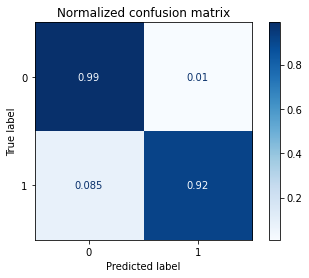

In [13]:
        '''
    No significant changes in xgboost classification observed. However misclassification of 0's as one did 
    reduce but not not significant to propose a model change

          '''

sm = BorderlineSMOTE(0.32,kind='borderline-1',random_state=42)
model_xgb = XGBClassifier(random_state= 42,scale_pos_weight=1/0.32)


pipe_xgb=make_pipeline(preprocessor,model_xgb)  
pipe_xgb.fit(X_train,y_train)
print(training_predict(pipe_xgb,X_train,y_train,X_test,y_test))
confusion_matrix_plot(pipe_xgb,X_test,y_test)   

{'auc': 0.9761042345226193, 'AP-SCORE': 0.9405013874103163, 'Recall_test': 0.90863890615289, 'Precision_test': 0.8236619718309859, 'F1_Score_test': 0.8640661938534279}
Confusion matrix, without normalization
Normalized confusion matrix


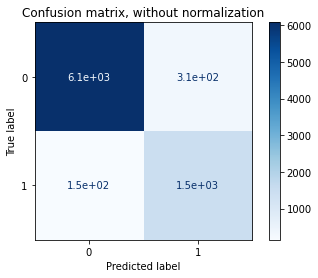

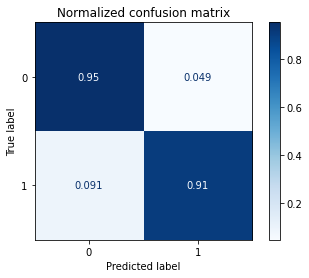

In [18]:
"""
A significant increase in classification of minority class was observed. classification accuracy of minority
   class jumped from 0.71 to 0.91 and incorrect classification of 1's as 0 reduced.
   This led me to select this model over previous baseline model even though no sognificant change in metrics were
   observed.

"""




sm = BorderlineSMOTE(0.32,kind='borderline-1',random_state=42)

stacked_clf = StackingClassifier(estimators=estimator_stacked, final_estimator= LogisticRegression(random_state=42,class_weight='balanced'))



pipe_stack=make_pipeline(preprocessor,sm,stacked_clf)  
pipe_stack.fit(X_train,y_train)
# print(training_predict(pipe_stack,X_train,y_train,X_test,y_test))
# confusion_matrix_plot(pipe_stack,X_test,y_test) 

In [5]:
estimator_stacked = [
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ("GBM" ,  GradientBoostingClassifier(random_state=42))
    ]


sm = BorderlineSMOTE(0.32,kind='borderline-1',random_state=42)

stacked_clf = StackingClassifier(estimators=estimator_stacked, final_estimator= LogisticRegression(random_state=42,class_weight='balanced'))



pipe_stack=make_pipeline(preprocessor,sm,stacked_clf)  
pipe_stack.fit(all_data,labels)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                 

In [7]:
#     ''''
# After smote I decided to print out predictions for smote-stacked ensemble model for submission as result1.csv
# Xgboost model was sent to further model tuning to refine accuracy

#     ''''
np.set_printoptions(suppress=True)
data_test=pd.read_csv("exercise_01_test.csv")
#### Cleaning data using custom function
data_test=data_clean(data_test)
# np.savetxt("result1.csv",pipe_stack.predict_proba(data_test)[:,1])

In [10]:
prediction=pipe_stack.predict(data_test)
len(prediction[np.where(prediction==1)])

2272